# **MODELADO PARA LA PRECIPITACIÓN EN EL ZÓCALO DE PUEBLA**



Precipitación v4:  
https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-monthly
https://www.ncei.noaa.gov/data/ghcnm/v4/precipitation/


Nombres:  
https://www.ncei.noaa.gov/pub/data/ghcn/v4/


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data=pd.read_csv('MXN00021035.csv')

In [ ]:
# Keep the 7th column (the one with the date)
pre=data.iloc[:,6]

# Keep the 6th column (the one with the temperature)
date=data.iloc[:,5]

# From 195210 to 1952/10 
date = date.astype(str).str.replace(r'(\d{4})(\d{2})', r'\1/\2', regex=True)

# Convert the date column to datetime
date = pd.to_datetime(date, format='%Y/%m')

In [ ]:
import matplotlib.pyplot as plt

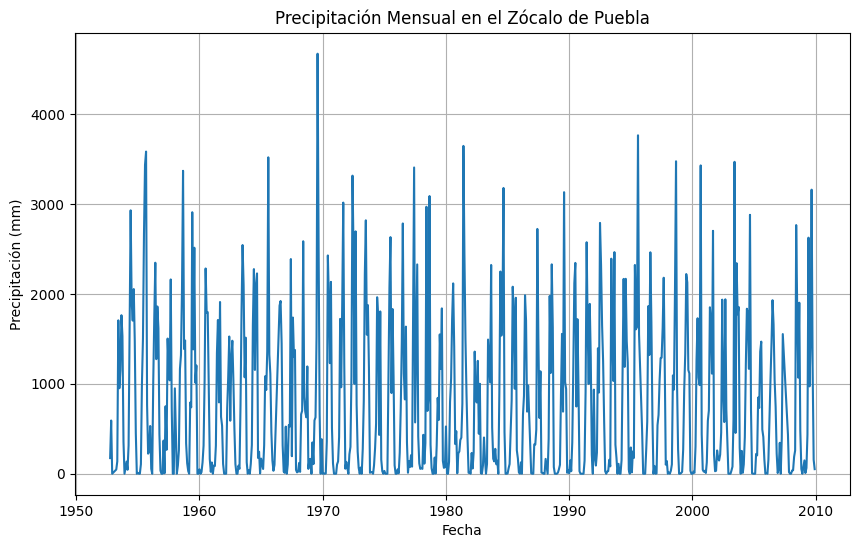

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(date, pre)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.title("Precipitación Mensual en el Zócalo de Puebla")
plt.grid(True)
plt.show()

# **TRANSFORMACIÓN**

# **ESTACIONARIEDAD**

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(pre)

(np.float64(-6.217559258126873),
 np.float64(5.319944160548207e-08),
 11,
 660,
 {'1%': np.float64(-3.440296841949105),
  '5%': np.float64(-2.8659291016222834),
  '10%': np.float64(-2.569107357667585)},
 np.float64(10188.524149780042))

In [ ]:
estacionariedad = adfuller(pre)

if estacionariedad[1] < 0.05:
    print("La serie es estacionaria", estacionariedad[1])

La serie es estacionaria 5.319944160548207e-08


## **AUTOCORRELACIONES**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.pyplot as plt

### **Autocorrelaciones Simples**

In [ ]:
autocorr_values = acf(pre, nlags=24)    # get the autocorrelations
autocorr_values = autocorr_values[1:]   # drop the first value (lag 0)

print(autocorr_values)

[ 0.50839258  0.23418155  0.01313411 -0.30708039 -0.52560174 -0.57512638
 -0.45457715 -0.24676928  0.05574702  0.28668487  0.51873702  0.62104148
  0.4223674   0.18726716 -0.05027177 -0.31533739 -0.51101384 -0.52356076
 -0.41372522 -0.19536916  0.07490439  0.29360553  0.49171041  0.55390038]


In [ ]:
def significancia(N, rhos):
    return 2 * np.sqrt(1 / (N) * (1 + 2 * sum(rho**2 for rho in rhos)))

In [ ]:
def FAC(N: int, rhos: list, print_rhos: bool = False) -> list:
    """
    Nos da la lista de los rhos significativos
    """
    significativos = []
    rho_list = [0] * len(rhos)
    
    updated_rhos = list(rho_list)  # Copy to retain original values when updating
    for i, r in enumerate(rhos):  # for index, rho in enumerate(r_list):
        threshold_value = significancia(N, updated_rhos)    # se actualiza el valor con los rhos significativos
        if abs(r) > threshold_value:
            if print_rhos: 
                print(f"rho {i+1} es significativo")
                print(f"{abs(r)} > {threshold_value}\n")

            updated_rhos[i] = r
            significativos.append((r, i+1))
        else:
            if print_rhos: 
                print(f"rho {i+1} no es significativo")
                print(f"{abs(r)} < {threshold_value}\n")

    print("Valores de autocorrelacion significativos:")
    for val, i in significativos:
        print(f"r{i}: {val}")

    return updated_rhos, significativos

In [ ]:
val_autocorr_sig, autocorr_sig = FAC(len(pre), autocorr_values) # Valores de autocorrelacion significativos, Autocorrelaciones significativas

Valores de autocorrelacion significativos:
r1: 0.5083925816973087
r2: 0.23418154549209602
r4: -0.30708039075409777
r5: -0.525601739269851
r6: -0.5751263827263251
r7: -0.4545771512790851
r8: -0.2467692768389855
r10: 0.28668487207593624
r11: 0.518737019797207
r12: 0.62104147830531
r13: 0.4223673959805745
r14: 0.18726715812704875
r16: -0.3153373882900101
r17: -0.5110138375479142
r18: -0.523560757866975
r19: -0.4137252180674527
r22: 0.29360552614549634
r23: 0.49171040803243543
r24: 0.5539003811525876


### **Autocorrelaciones Simples**

In [ ]:
pacf_values = pacf(pre, nlags=24)
pacf_values = pacf_values[1:]       # drop the first value (lag 0)
print(pacf_values)

[ 0.50915025 -0.03287594 -0.12647798 -0.35612797 -0.33894795 -0.27403763
 -0.13857567 -0.08223542  0.05576356  0.01318253  0.19534353  0.25851008
  0.02594096 -0.00088725  0.01740651 -0.00537288 -0.06427178 -0.05420949
 -0.07395753 -0.03629151 -0.02303549 -0.04347716  0.04677814  0.11135938]


In [ ]:
def intervalo(N):
    "Esta es de las autocorrelaciones parciales"
    return 2*np.sqrt(1/ N)

In [ ]:
def FACP(N: int, rho_list: list, print_rhos: bool = False) -> list:
    """
    Esta función nos da la lista de los rhos significativos
    """
    
    fueradelintervalo = intervalo(N)
    significativos = []

    for i, r in enumerate(rho_list):
        
        if abs(r) > fueradelintervalo:
            if print_rhos: 
                print(f"rho {i+1} es significativo")
                print(f"{abs(r)} > {fueradelintervalo}\n")
            significativos.append((r, i+1))
        else:
            if print_rhos: 
                print(f"rho {i+1} no es significativo")
                print(f"{abs(r)} < {fueradelintervalo}\n")
                pass

    print(f"Valores de autocorrelacion parcial significativos:")
    for r, i in significativos:
        print(f"rho {i}: {r}")

    return significativos

In [ ]:
facp_sig = FACP(len(pre), pacf_values)

Valores de autocorrelacion parcial significativos:
rho 1: 0.5091502457534897
rho 3: -0.12647798109479702
rho 4: -0.3561279660010308
rho 5: -0.3389479485953009
rho 6: -0.2740376325288502
rho 7: -0.13857567141649174
rho 8: -0.0822354191788456
rho 11: 0.19534353456529419
rho 12: 0.2585100818536459
rho 24: 0.11135938181397906


## **plot**

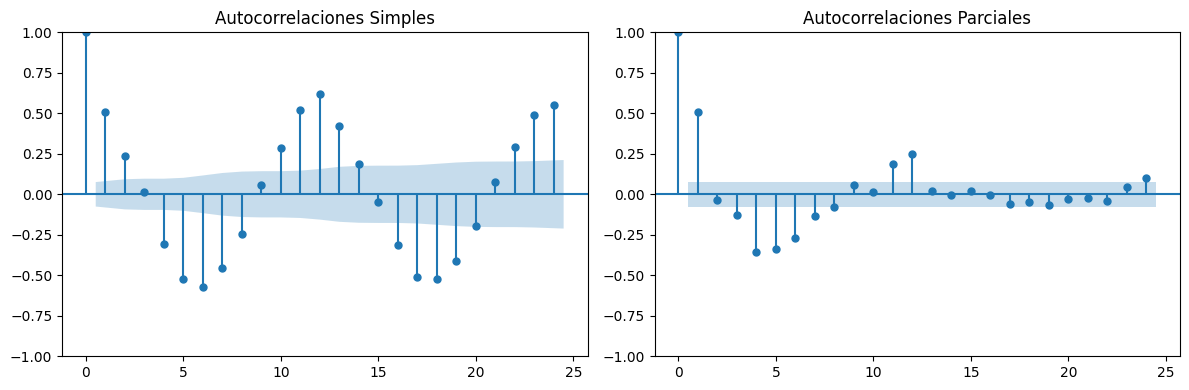

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(pre, lags=24, ax=axs[0])
# axs[0].set_ylim(-0.04, 0.04)
axs[0].set_title('Autocorrelaciones Simples')

plot_pacf(pre, lags=24, ax=axs[1])
# axs[1].set_ylim(-0.04, 0.04)
axs[1].set_title('Autocorrelaciones Parciales')

plt.tight_layout()
plt.show()


In [ ]:
print("Valores de autocorrelacion significativos:")
for val, i in autocorr_sig:
    print(f"r{i}: {val}")

Valores de autocorrelacion significativos:
r1: 0.5083925816973087
r2: 0.23418154549209602
r4: -0.30708039075409777
r5: -0.525601739269851
r6: -0.5751263827263251
r7: -0.4545771512790851
r8: -0.2467692768389855
r10: 0.28668487207593624
r11: 0.518737019797207
r12: 0.62104147830531
r13: 0.4223673959805745
r14: 0.18726715812704875
r16: -0.3153373882900101
r17: -0.5110138375479142
r18: -0.523560757866975
r19: -0.4137252180674527
r22: 0.29360552614549634
r23: 0.49171040803243543
r24: 0.5539003811525876


In [ ]:
print(f"Valores de autocorrelacion parcial significativos:")
for r, i in facp_sig:
    print(f"rho {i}: {r}")

Valores de autocorrelacion parcial significativos:
rho 1: 0.5091502457534897
rho 3: -0.12647798109479702
rho 4: -0.3561279660010308
rho 5: -0.3389479485953009
rho 6: -0.2740376325288502
rho 7: -0.13857567141649174
rho 8: -0.0822354191788456
rho 11: 0.19534353456529419
rho 12: 0.2585100818536459
rho 24: 0.11135938181397906


## **MODELADO**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
modelo=SARIMAX(pre,
               order=(1,0,0),
               seasonal_order=(1,0,1,12)).fit()

In [ ]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 1927   No. Observations:                  672
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -5295.998
Date:                              Tue, 22 Apr 2025   AIC                          10599.996
Time:                                      15:19:02   BIC                          10618.037
Sample:                                           0   HQIC                         10606.983
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1954      0.031      6.256      0.000       0.134       0.257
ar.S.L12       0.9661      0.009    110.797      0.000       0.949       0.983
ma.S.L12      -0.6408      0.029    -21.948      0.000      -0.698      -0.584
sigma2      4.006e+05   1.48e+04     27.137      0.000    3.72e+05    4.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               269.09
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.72
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
diagnostic = modelo.plot_diagnostics(figsize=(12, 8))
plt.show()

NameError: name 'modelo' is not defined

In [ ]:
# add bon 

(-0.5, 0.5)

# **una libreria que busca el mejor ARIMA**

In [ ]:
import pmdarima as pm

# Find the best SARIMA model
auto_sarima_model = pm.auto_arima(pre, 
                                  seasonal=True, 
                                  m=12,  # Monthly data, so seasonality is 12
                                  stepwise=True, 
                                  suppress_warnings=True, 
                                  trace=True)

# Display the summary of the best model
auto_sarima_model.summary()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## **VERIFICACION DE SUPUESTOS**

## **Principio de Parsimonia**

In [ ]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 1927   No. Observations:                  672
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -5295.998
Date:                              Tue, 22 Apr 2025   AIC                          10599.996
Time:                                      14:39:05   BIC                          10618.037
Sample:                                           0   HQIC                         10606.983
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1954      0.031      6.256      0.000       0.134       0.257
ar.S.L12       0.9661      0.009    110.797      0.000       0.949       0.983
ma.S.L12      -0.6408      0.029    -21.948      0.000      -0.698      -0.584
sigma2      4.006e+05   1.48e+04     27.137      0.000    3.72e+05    4.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               269.09
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.72
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print("Verificacion de los residuos")

# get the Prob(JB) value using the Jarque-Bera test
jb_test = resultado.test_normality(method='jarquebera')
jb_test

# get the Ljung-Box test results



Verificacion de los residuos


NameError: name 'resultado' is not defined

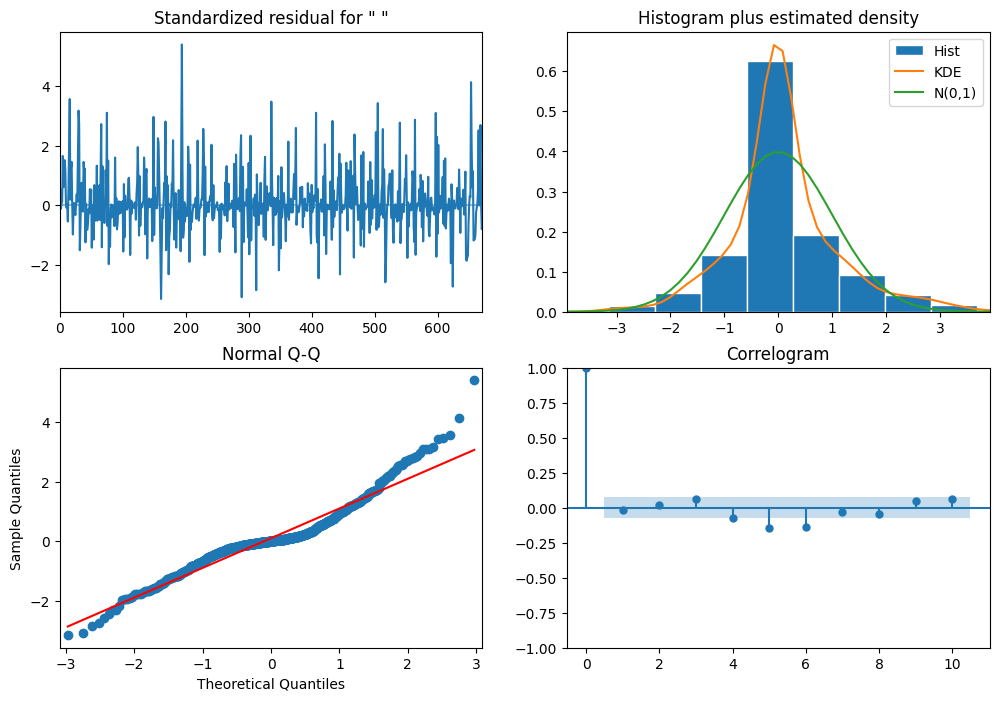

In [ ]:
diagnostic = resultado.plot_diagnostics(figsize=(12, 8))
plt.show()

## **Analisis de Residuos**

In [ ]:
residuos = resultado.resid.dropna()

### **Media Cero**

In [ ]:
from scipy.stats import t as t_dist

In [ ]:
from scipy.stats import ttest_1samp

# H0: The mean of the residuals is equal to 0
# H1: The mean of the residuals is not equal to 0

mediacero = ttest_1samp(residuos, 0)

print(mediacero)
print(f'p-value: {mediacero.pvalue}')
if mediacero.pvalue < 0.05:
    print("La media de los residuos es diferente de cero")
else:  
    print("La media de los residuos es igual a cero")

print(f"\nt-statistic: {mediacero.statistic}")
print(f"p-value: {mediacero.pvalue}")
print(f"t-distribution: {t_dist(df=len(residuos)-1).pdf(mediacero.statistic)}")

TtestResult(statistic=np.float64(2.883298891576977), pvalue=np.float64(0.004061336578803261), df=np.int64(671))
p-value: 0.004061336578803261
La media de los residuos es diferente de cero

t-statistic: 2.883298891576977
p-value: 0.004061336578803261
t-distribution: 0.00636694900689484


In [ ]:
from scipy.stats import wilcoxon

# H0: The median of the residuals is equal to 0
# H1: The median of the residuals is not equal to 0
wilcoxon(residuos)

WilcoxonResult(statistic=np.float64(106129.0), pvalue=np.float64(0.16835069054413332))

El p-valor es muy pequeño, entonces la mediana podría ser diferente de cero :(

In [ ]:
from statsmodels.stats.descriptivestats import sign_test

# H0: The median of the residuals is equal to 0
# H1: The median of the residuals is not equal to 0
sign_test(residuos)

(np.float64(3.0), np.float64(0.8470716605780383))

### **Distribucion Normal**

In [ ]:
from scipy.stats import jarque_bera

normal = jarque_bera(residuos)

print(f"Jarque-Bera statistic: {normal.statistic}")
print(f"p-value: {normal.pvalue}")
if normal.pvalue < 0.05:
    print("Los residuos no son normales")
else:
    print("Los residuos son normales")

Jarque-Bera statistic: 265.0340916440634
p-value: 2.809171420244167e-58
Los residuos no son normales


In [ ]:
from statsmodels.stats.diagnostic import lilliefors
# Estadistico, p-valor
lilliefors(residuos)

(0.09739134988068032, 0.0009999999999998899)

In [ ]:
from scipy.stats import kstest
# Estadistico, p-valor
kstest(residuos, 'norm')

KstestResult(statistic=0.47835200408367273, pvalue=0.0, statistic_location=0.03477562902544919, statistic_sign=1)

In [ ]:
from scipy.stats import normaltest

normaltest(residuos)

NormaltestResult(statistic=6712.437462125869, pvalue=0.0)

In [ ]:
from scipy.stats import anderson

anderson(residuos)

AndersonResult(statistic=592.7394435289825, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.2659254022142346e-06, scale=0.011949027349192001)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

### **Varianza Constante**

In [ ]:
from statsmodels.tools.tools import add_constant

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
# H0: Homocedasticidad (varianza constante)
# H1: Heterocedasticidad (varianza no constante)

# Add a constant to the exogenous variables
exog = add_constant(returns)

# Perform the test
stat, p_value, _, _ = het_breuschpagan(residuos, exog)
print(f'Statistic: {stat}, p-value: {p_value}') # p-value > 0.05, homocedasticidad (variancia constante)

Statistic: 295.1704213802668, p-value: 3.715369009463656e-66


### **Independencia**

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuos, lags=10)

,lb_stat,lb_pvalue
1,0.034522,0.852602
2,0.055283,0.972737
3,0.088842,0.993142
4,0.110325,0.998533
5,0.114579,0.999773
6,0.114734,0.999970
7,0.118451,0.999996
8,0.120753,0.999999
9,0.123433,1.000000
10,7.427250,0.684587


como todos los p-valores son mayores a 0.05, no hay evidencia de correlacion significativa entre los lags

### **Modelo admisible**

es Estacionario e einvertible

# **PREDICCIÓN DEL SIGUIENTE DÍA**